Etapa 1: Lectura y procesamiento inicial

In [41]:
# 1.1 Carga y primera inspección
print("\n1.1 CARGA Y PRIMERA INSPECCIÓN")
print("-" * 35)

import pandas as pd

# Cargar los datos
df = pd.read_csv('registro_llegadas_a_medellin_dic2024 (1).csv', sep=';', encoding='utf-8')

print(f"✓ Dataset cargado exitosamente")
print(f"✓ Dimensiones del dataset: {df.shape[0]} filas × {df.shape[1]} columnas")

# Información básica del dataset
print("\nPrimeras 5 filas:")
print(df.head())

print("\nÚltimas 5 filas:")
print(df.tail())

print("\nTipos de datos:")
print(df.dtypes)

print("\nNombres de columnas:")
print(df.columns.tolist())

# 1.2 Evaluación de calidad
print("\n\n1.2 EVALUACIÓN DE CALIDAD")
print("-" * 25)

# Datos faltantes
print("Datos faltantes por columna:")
missing_data = df.isnull().sum()
for col in df.columns:
    missing_count = missing_data[col]
    missing_pct = (missing_count / len(df)) * 100
    print(f"  - {col}: {missing_count} ({missing_pct:.2f}%)")

# Duplicados
print("\nRegistros duplicados:")

total_duplicados = df.duplicated().sum()

if total_duplicados ==0:
    print("No se encontraron registros duplicados")
else:
    print(f"\nTotal registros duplicados encontrados : {total_duplicados} ({(total_duplicados/len(df)*100):.2f}%) \n")

    duplicados = df.groupby(['fecha_salida', 'duracion_minutos']).size().reset_index(name='veces_duplicado')
    # Filtra solo los registros que están duplicados (aparecen más de una vez)
    duplicados = duplicados[duplicados['veces_duplicado'] > 1]
    print(duplicados)

# Valores únicos por columna
print(f"\nValores únicos por columna:")
for col in df.columns:
  print(f"{col}: {df[col].nunique()} valores únicos")

# Crear copia para no modificar original
df_procesado = df.copy()


# Conversión de fecha y validación de consistencia
print(f"\nConversión y validación de fechas:")
try:
    df_procesado['fecha_salida'] = pd.to_datetime(df_procesado['fecha_salida'])
    print("✓ Conversión de fechas exitosa")

except Exception as e:
    print(f"✗ Error en conversión de fechas: Posible inconsistencia de formato\n")

try:
    print('Intentando conversión de fechas con formato mezclado... un momento por favor!')
    # Convertir la columna de fecha_salida a datetime, previendo formatos mezclados
    df_procesado['fecha_salida'] = pd.to_datetime(df_procesado['fecha_salida'], format='mixed')
    print("✓ Conversión de fechas exitosa")

    # Rango temporal
    fecha_min = df_procesado['fecha_salida'].min()
    fecha_max = df_procesado['fecha_salida'].max()
    duracion = fecha_max - fecha_min

    print(f"✓ Rango temporal: {fecha_min} a {fecha_max}")
    print(f"✓ Duración total: {duracion.days} días, {duracion.seconds//3600} horas")

except Exception as e:
    print(f"✗ Error en conversión de fechas: {e}")

# 1.4. Análisis univariado - Variables temporales - Fecha de Observación

print("\n1.4. Análisis univariado - Variables temporales - Fecha de Observación")
print("-" * 72)

# Ordenar por fecha
df_ordenado = df_procesado.sort_values('fecha_salida')

# Calcular diferencias temporales
df_ordenado['diff_tiempo'] = df_ordenado['fecha_salida'].diff()

# Estadísticas de intervalos
intervalos = df_ordenado['diff_tiempo'].dropna()
moda_intervalos = intervalos.mode()

# Estadísticas de intervalos
intervalos = df_ordenado['diff_tiempo'].dropna()
moda_intervalos = intervalos.mode()

print(f"\nIntervalos entre mediciones:")
print(f"  Mínimo: {intervalos.min()}")
print(f"  Máximo: {intervalos.max()}")
print(f"  Promedio: {intervalos.mean()}")
print(f"  Mediana: {intervalos.median()}")
print(f"  Moda: {moda_intervalos.iloc[0]}")

# Frecuencias más comunes
frecuencias_comunes = intervalos.value_counts().head(10)
print(f"\nIntervalos más frecuentes:")
for intervalo, cantidad in frecuencias_comunes.items():
    print(f"  {intervalo}: {cantidad} veces ({cantidad/len(intervalos)*100:.1f}%)")


1.1 CARGA Y PRIMERA INSPECCIÓN
-----------------------------------
✓ Dataset cargado exitosamente
✓ Dimensiones del dataset: 3372 filas × 2 columnas

Primeras 5 filas:
     fecha_salida  duracion_minutos
0  1/12/2024 4:45                71
1  1/12/2024 5:35                67
2  1/12/2024 6:00                80
3  1/12/2024 6:30                60
4  1/12/2024 6:30                64

Últimas 5 filas:
          fecha_salida  duracion_minutos
3367  31/12/2024 19:00               100
3368  31/12/2024 19:15                67
3369  31/12/2024 20:00                75
3370  31/12/2024 20:00                76
3371  31/12/2024 21:00                83

Tipos de datos:
fecha_salida        object
duracion_minutos     int64
dtype: object

Nombres de columnas:
['fecha_salida', 'duracion_minutos']


1.2 EVALUACIÓN DE CALIDAD
-------------------------
Datos faltantes por columna:
  - fecha_salida: 0 (0.00%)
  - duracion_minutos: 0 (0.00%)

Registros duplicados:

Total registros duplicados encontrados :

Etapa 2: Identificar outliers SIN eliminarlos.

In [18]:
# 1.3. Análisis univariado - Variables numéricas - Duración en minutos

print("\n1.3 Análisis univariado - Variables numéricas - Duración en minutos")
print("-" * 80)

# Estadísticas descriptivas básicas
print("Estadísticas descriptivas de temperatura:")
stats_desc = df['duracion_minutos'].describe()
print(stats_desc)

# Detección de outliers usando IQR
Q1 = df['duracion_minutos'].quantile(0.25)
Q3 = df['duracion_minutos'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['duracion_minutos'] < limite_inferior) |
              (df['duracion_minutos'] > limite_superior)]

print(f"\nDetección de outliers (método IQR):")
print(f"  - Límite inferior: {limite_inferior:.2f} min")
print(f"  - Límite superior: {limite_superior:.2f} min")
print(f"  - Outliers detectados: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

if len(outliers) > 0:
    # Contar frecuencia de cada valor outlier
    outlier_counts = outliers['duracion_minutos'].value_counts().sort_index()
    print(f"\n  - Detalle de outliers encontrados:")

    for temp_value, count in outlier_counts.items():
        porcentaje = (count / len(outliers)) * 100
        tipo_outlier = "inferior" if temp_value < limite_inferior else "superior"
        print(f"    • {temp_value:.1f} min: {count} veces ({porcentaje:.1f}% de outliers) - Límite {tipo_outlier}")

    # Estadísticas adicionales de outliers
    print(f"\n  - Resumen de outliers:")
    print(f"    • Valor outlier más frecuente: {outlier_counts.idxmax():.1f} min ({outlier_counts.max()} veces)")
    print(f"    • Valor outlier más extremo: {outlier_counts.index[0] if outlier_counts.index[0] < limite_inferior else outlier_counts.index[-1]:.1f} min")
    print(f"    • Rango de outliers: {outlier_counts.index.min():.1f} min - {outlier_counts.index.max():.1f} min")

print("\n\n\n")


1.3 Análisis univariado - Variables numéricas - Duración en minutos
--------------------------------------------------------------------------------
Estadísticas descriptivas de temperatura:
count    3372.000000
mean       74.131376
std        21.771560
min         6.000000
25%        63.000000
50%        70.000000
75%        80.000000
max       806.000000
Name: duracion_minutos, dtype: float64

Detección de outliers (método IQR):
  - Límite inferior: 37.50 min
  - Límite superior: 105.50 min
  - Outliers detectados: 178 (5.28%)

  - Detalle de outliers encontrados:
    • 6.0 min: 1 veces (0.6% de outliers) - Límite inferior
    • 9.0 min: 1 veces (0.6% de outliers) - Límite inferior
    • 15.0 min: 1 veces (0.6% de outliers) - Límite inferior
    • 17.0 min: 1 veces (0.6% de outliers) - Límite inferior
    • 20.0 min: 1 veces (0.6% de outliers) - Límite inferior
    • 24.0 min: 1 veces (0.6% de outliers) - Límite inferior
    • 25.0 min: 1 veces (0.6% de outliers) - Límite inferior
 

Etapa 3: Identificar comportamiento por hora del día y por día de la semana.

In [30]:


# 1.5. Análisis de patrones temporales - Fecha de Observación

print("\n1.5. Análisis de patrones temporales - Fecha de salida")
print("-" * 72)

# Crear características temporales
df_temporal = df_procesado.copy()
df_temporal['hora'] = df_temporal['fecha_salida'].dt.hour
df_temporal['dia_semana'] = df_temporal['fecha_salida'].dt.dayofweek  # 0=Lunes, 6=Domingo
df_temporal['dia_semana_nombre'] = df_temporal['fecha_salida'].dt.day_name()
dias_semana_map = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sábado',
    6: 'Domingo'
}
df_temporal['dia_semana_nombre'] = df_temporal['dia_semana'].map(dias_semana_map)

print("Características temporales extraídas: hora, día_semana, semana_año, mes")

# Análisis por hora del día
print(f"\n--- Análisis por Hora del Día ---")
temp_por_hora = df_temporal.groupby('hora')['duracion_minutos'].agg([
    'count', 'mean', 'min', 'max'
]).round(2)
temp_por_hora.columns = ['Mediciones', 'Promedio', 'Mínimo', 'Máximo']

print("Estadísticas de temperatura por hora:")
print(temp_por_hora)

# Análisis por dia de la semana
print(f"\n--- Análisis por Día de la Semana ---")
temp_por_dia = df_temporal.groupby(['dia_semana', 'dia_semana_nombre'])['duracion_minutos'].agg([
    'count', 'mean', 'min', 'max'
]).round(2)
temp_por_dia.columns = ['Mediciones', 'Promedio', 'Mínimo', 'Máximo']

print("Estadísticas de temperatura por día de la semana:")
print(temp_por_dia)


1.5. Análisis de patrones temporales - Fecha de salida
------------------------------------------------------------------------
Características temporales extraídas: hora, día_semana, semana_año, mes

--- Análisis por Hora del Día ---
Estadísticas de temperatura por hora:
      Mediciones  Promedio  Mínimo  Máximo
hora                                      
3              3     68.00      64      72
4             21    108.00      62     806
5            132     72.35      37     180
6            159     69.70      49     131
7            204     70.57      15     145
8            220     68.94       9     128
9            222     73.34      47     166
10           223     74.30       6     200
11           214     71.85      24     157
12           223     72.07      34     180
13           193     74.79      52     146
14           238     78.35      35     361
15           271     75.13      20     145
16           234     77.09      25     152
17           268     77.54      48    

Etapa 4: Visualizaciones

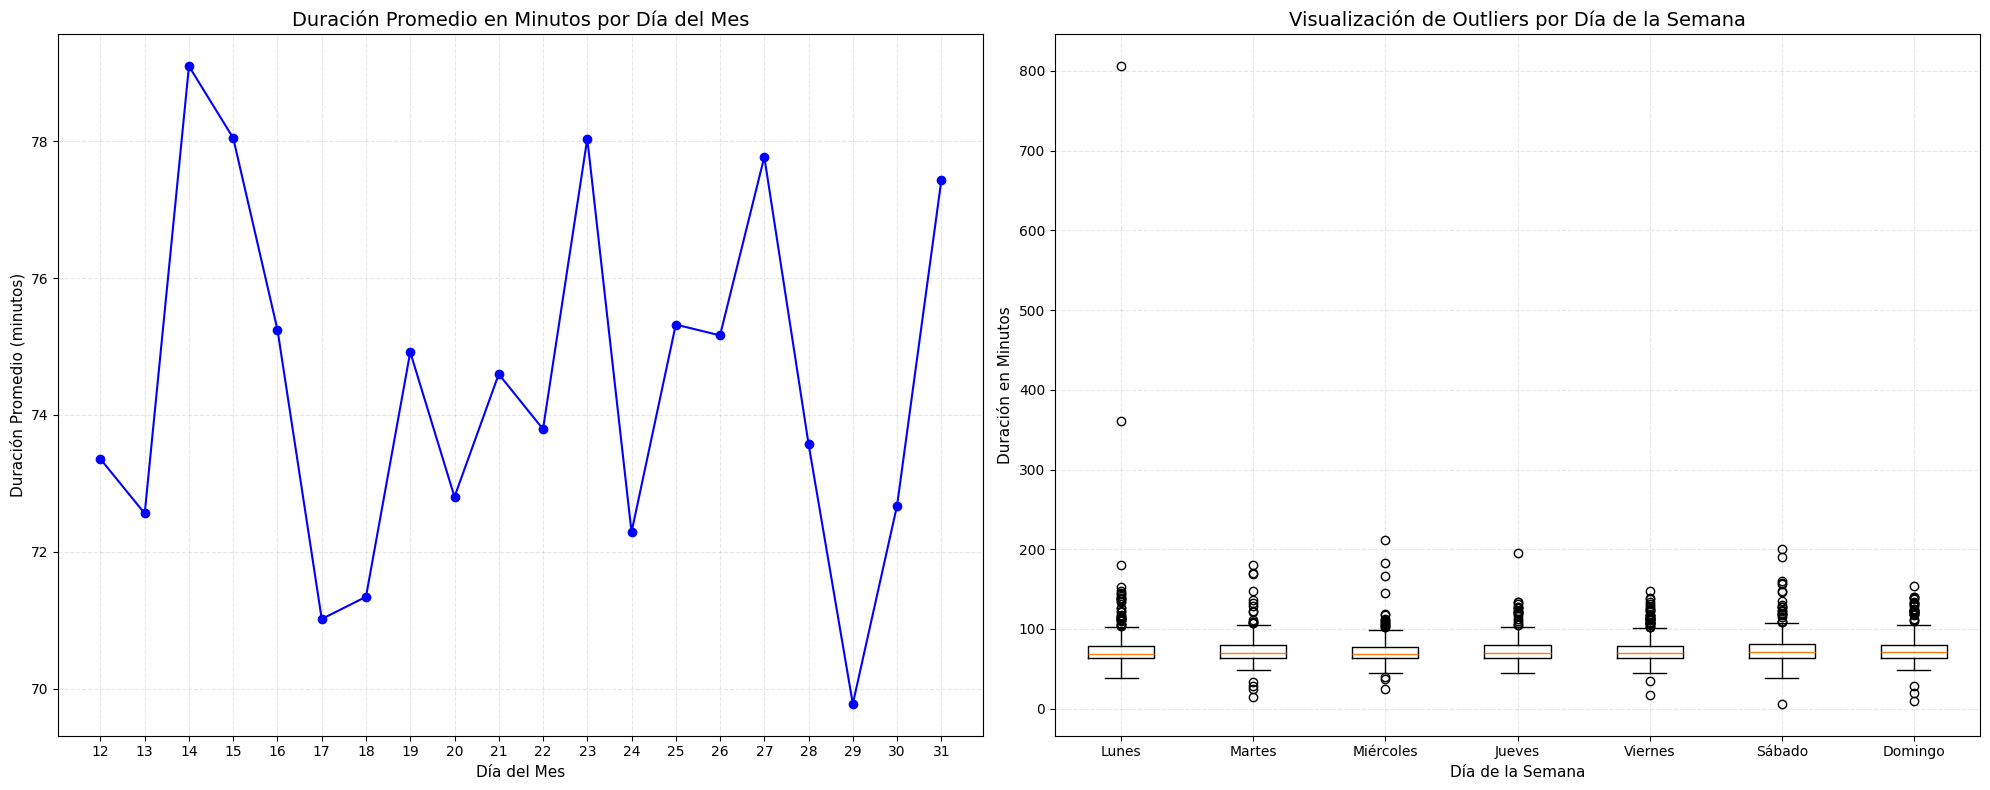

In [37]:
import matplotlib.pyplot as plt

promedio_por_dia_mes = df_temporal.groupby('dia_mes')['duracion_minutos'].mean()

orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
datos_boxplot = [df_temporal[df_temporal['dia_semana_nombre'] == dia]['duracion_minutos'].dropna() for dia in orden_dias]

# 2. Configurar la figura y los subgráficos
# Crea una figura con 1 fila y 2 columnas para los gráficos.
fig, axes = plt.subplots(1, 2, figsize=(20, 8))


# 3. Gráfico 1: Duración promedio por día del mes
axes[0].plot(promedio_por_dia_mes.index, promedio_por_dia_mes.values, marker='o', color='blue')
axes[0].set_title('Duración Promedio en Minutos por Día del Mes', fontsize=14)
axes[0].set_xlabel('Día del Mes', fontsize=11)
axes[0].set_ylabel('Duración Promedio (minutos)', fontsize=11)
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].set_xticks(promedio_por_dia_mes.index)


# 4. Gráfico 2: Outliers por día de la semana (Boxplot)
axes[1].boxplot(datos_boxplot, tick_labels=orden_dias)
axes[1].set_title('Visualización de Outliers por Día de la Semana', fontsize=14)
axes[1].set_xlabel('Día de la Semana', fontsize=11)
axes[1].set_ylabel('Duración en Minutos', fontsize=11)
axes[1].grid(True, linestyle='--', alpha=0.3)


# 5. Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

Etapa 5: Preguntas de interpretación de códigos y resultados

1. ¿Qué patrones temporales identificaste en las duraciones de los viajes?

Identifiqué que los viajes en su mayoria se dan en la madrugada, siendo el mas común a la media noche, abarcando el 40.6% de viajes.

2. ¿Qué puedes decir de la tendencia de comportamiento de los outliers para cada día de la
semana?

De los outliers podemos identificar que los lunes ocurren los outliers mas extremos, el martes es el dia con menos outliers, ademas de que el jueves y el viernes es cuando mas outliers ocurren.

3. ¿Qué justificación le podrías dar a los outliers más extremos? Que crees que los pudo
haber causado?

Tengo la teoría de que los outliers mas extremos ocurrieron debido a fallos con la medición, o algun error con las maquinas las cuales median los tiempos.

4. ¿Cuáles fueron los principales desafíos de calidad de datos y cómo los resolviste?

El mayor desafío de calidad de datos fue la conversión de la fecha, ya que habian varios datos que no tenian el mismo formato de fecha.

5. ¿Qué recomendaciones harías para mejorar la recolección de datos futura?


*   Tener un mejor protocolo de mantenimiento de las maquinas de medición del tiempo
*   Guardar las fechas con un mismo formato

